In [9]:
import numpy as np
import matplotlib.pyplot as plt
from spec_id import Gen_spec, Median_w_Error_cont
import seaborn as sea
import pandas as pd
from glob import glob
from astropy.io import fits
from astropy.table import Table
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [3]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [5]:
lzDB

,gids,ids,ra,dec,hi_res_specz,lmass,tau,Z_f,Z_-_sig_f,Z_+_sig_f,...,t_+_sig_cal,tx_cal,tx_-_sig_cal,tx_+_sig_cal,Zx_cal,Zx_-_sig_cal,Zx_+_sig_cal,Z_cal,Z_-_sig_cal,Z_+_sig_cal
49,n16758,16758,189.162357,62.224840,1.014,10.83,0.00,0.020,0.001,0.002,...,0.666,3.916834,0.716433,0.749499,0.013952,0.001852,0.002693,0.014,0.002,0.003
58,n19442,19442,189.123036,62.237460,1.101,10.10,8.90,0.015,0.009,0.010,...,1.041,2.583166,0.771543,1.058116,0.013671,0.008192,0.010717,0.014,0.009,0.010
69,n23435,23435,189.338306,62.256571,1.134,10.27,8.60,0.014,0.006,0.009,...,0.827,3.112224,0.760521,0.914830,0.012044,0.005780,0.010156,0.013,0.007,0.009
86,n32566,32566,189.161280,62.307577,1.150,10.61,8.70,0.020,0.008,0.006,...,0.395,2.032064,0.683367,0.462926,0.021190,0.008136,0.006004,0.022,0.009,0.005
96,n34694,34694,189.147840,62.323647,1.145,10.94,8.30,0.015,0.006,0.005,...,0.963,2.803607,0.462926,0.958918,0.014345,0.004882,0.005667,0.015,0.006,0.005
220,s39170,39170,53.041826,-27.725868,1.022,11.09,8.48,0.023,0.005,0.004,...,0.195,2.219439,1.025050,0.275551,0.028766,0.001964,0.000954,0.029,0.002,0.001
221,s39241,39241,53.042327,-27.726209,1.019,10.87,8.30,0.022,0.003,0.004,...,0.424,2.506012,0.529058,0.518036,0.023603,0.006397,0.004601,0.024,0.007,0.004
223,s39631,39631,53.042169,-27.725928,1.053,10.69,8.78,0.018,0.004,0.006,...,0.865,3.993988,0.969940,0.870741,0.007106,0.002525,0.008024,0.008,0.003,0.007
246,s43615,43615,53.093057,-27.707368,1.016,10.69,0.00,0.027,0.004,0.002,...,0.732,3.960922,0.606212,0.771543,0.021190,0.004713,0.005499,0.022,0.006,0.005
258,s45972,45972,53.115984,-27.693568,1.038,10.87,8.00,0.012,0.003,0.002,...,0.669,3.685371,0.870741,0.683367,0.010473,0.003816,0.004657,0.011,0.004,0.004


In [54]:
spec = Gen_spec(galDB.gids[270],1.016)

../data/galaxy_flts/s48631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s48631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s48631_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s48631_flt: save ../data/galaxy_flts/s48631_flt.detect_seg.fits, ../data/galaxy_flts/s48631_flt.detect.cat


In [21]:
spec_t1 = fits.open('/Volumes/Vince_research/Extractions/Quiescent_galaxies/s48631/GS2-01-189-G102_48631.1D.fits')
spec_t2 = fits.open('/Volumes/Vince_research/Extractions/Quiescent_galaxies/s48631/GS2-02-189-G102_48631.1D.fits')

In [34]:
spec_t1[1].columns

ColDefs(
    name = 'wave'; format = 'D'; unit = 'ANGSTROMS'
    name = 'flux'; format = 'D'; unit = 'ELECTRONS/S'
    name = 'error'; format = 'D'; unit = 'ELECTRONS/S'
    name = 'contam'; format = 'D'; unit = 'ELECTRONS/S'
    name = 'trace'; format = 'D'; unit = 'ELECTRONS/S'
    name = 'etrace'; format = 'D'; unit = 'ELECTRONS/S'
    name = 'sensitivity'; format = 'D'; unit = 'E/S / 1E-17 CGS'
)

In [23]:
wv1 = spec_t1[1].data['wave']
fl1 = spec_t1[1].data['flux'] / spec_t1[1].data['sensitivity']
er1 = spec_t1[1].data['error'] / spec_t1[1].data['sensitivity']

IDX1 = [U for U in range(len(wv1)) if 7900 < wv1[U] < 11300]

wv2 = spec_t2[1].data['wave']
fl2 = spec_t2[1].data['flux'] / spec_t2[1].data['sensitivity']
er2 = spec_t2[1].data['error'] / spec_t2[1].data['sensitivity']

IDX2 = [U for U in range(len(wv2)) if 7900 < wv2[U] < 11300]

In [30]:
flgrid = np.array([fl1,fl2]).T
weigrid = (1 / np.array([er1,er2]).T)**2

In [31]:
stack, err = np.zeros([2, len(wv1)])
for i in range(len(wv1)):
    stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
    err[i] = 1 / np.sqrt(np.sum(weigrid[i]))

<Container object of 3 artists>

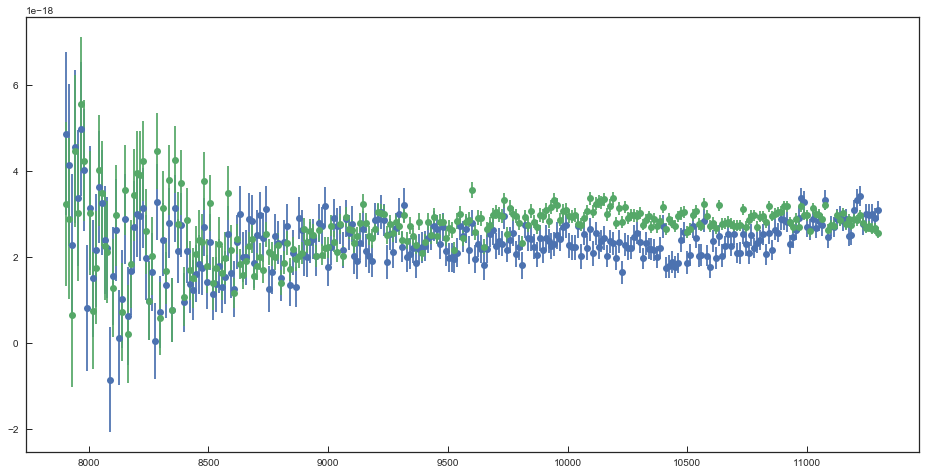

In [36]:
plt.figure(figsize=[16,8])
plt.errorbar(wv1[IDX2],stack[IDX2]*1E-17,err[IDX2]*1E-17,fmt='o')
plt.errorbar(spec.gal_wv,spec.gal_fl*1.5,spec.gal_er,fmt='o')

<Container object of 3 artists>

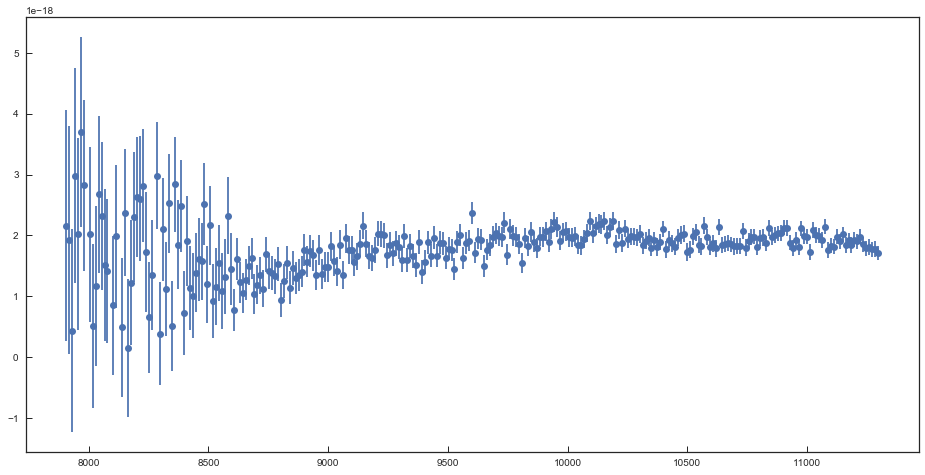

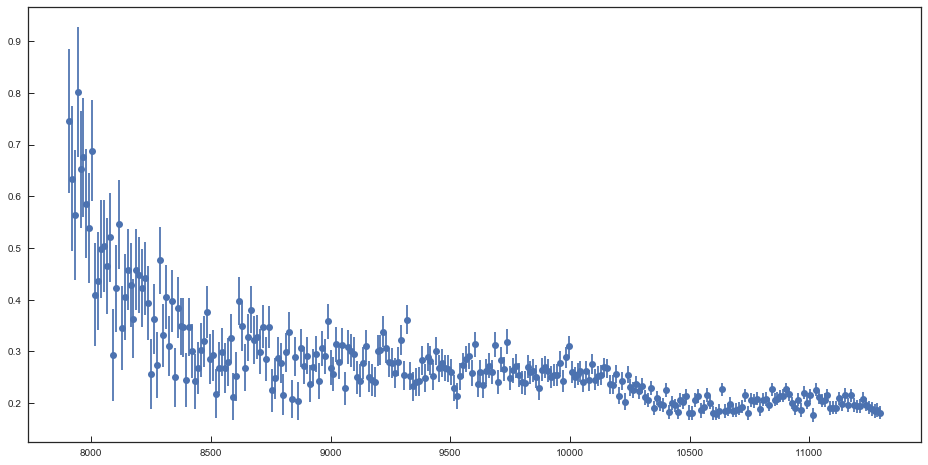

In [20]:
%matplotlib inline

plt.figure(figsize=[16,8])
plt.errorbar(spec.gal_wv,spec.gal_fl,spec.gal_er,fmt='o')

plt.figure(figsize=[16,8])
plt.errorbar(wv[IDX],fl[IDX],er[IDX],fmt='o')

In [37]:
np.save('../spec_stacks_june14/s48631_stack_2.npy',[wv,stack,err])

In [39]:
og_db = pd.read_pickle('../data/good_spec_gal_DB.pkl')

In [40]:
og_db

,gids,ids,redshift,hmag,ra,dec,agn,in_data,spec,flt_files,flt_xpos,flt_ypos,low_res_specz,hi_res_specz
43,n14713,14713,1.134,22.557517,189.236333,62.214608,False,True,True,../../../Clear_data/flt_files/icat12tqq_flt.fits,480.823147,636.879341,1.224,1.232
47,n15616,15616,1.250,23.162718,189.238403,62.218809,False,True,True,../../../Clear_data/flt_files/icat12tqq_flt.fits,557.760340,731.676403,0.790,0.787
49,n16758,16758,0.992,21.618617,189.162357,62.224840,False,True,True,../../../Clear_data/flt_files/icxt36jqq_flt.fits,103.350402,901.345306,1.012,1.014
50,n17070,17070,1.226,21.592234,189.268086,62.226445,False,True,True,../../../Clear_data/flt_files/icat25hcq_flt.fits,637.268350,823.317758,1.116,1.192
51,n17436,17436,0.869,22.379914,189.171078,62.227726,False,True,True,../../../Clear_data/flt_files/icxt36jmq_flt.fits,20.935569,1013.208080,0.899,0.903
58,n19442,19442,1.007,23.317546,189.123036,62.237460,False,True,True,../../../Clear_data/flt_files/icat03dzq_flt.fits,30.768618,1009.307349,1.217,1.101
61,n21156,21156,1.201,21.327907,189.239409,62.247548,False,True,True,../../../Clear_data/flt_files/icxt51jvq_flt.fits,279.865494,838.707094,1.251,1.251
62,n21427,21427,1.479,22.540644,189.368121,62.247344,False,True,True,../../../Clear_data/flt_files/icat26dyq_flt.fits,-19.664813,572.418137,1.579,1.514
68,n23254,23254,1.457,23.460559,189.349606,62.255761,False,True,True,../../../Clear_data/flt_files/icat26dyq_flt.fits,290.163896,661.958820,0.977,0.974
69,n23435,23435,1.092,22.902048,189.338306,62.256571,False,True,True,../../../Clear_data/flt_files/icat26dyq_flt.fits,422.330798,604.972381,1.132,1.134


In [46]:
z,pz = np.load('../rshift_dat/s48631_t8.7_2__Pofz.npy')
z2,pz2 = np.load('../rshift_dat/s48631_hires_Pofz.npy')

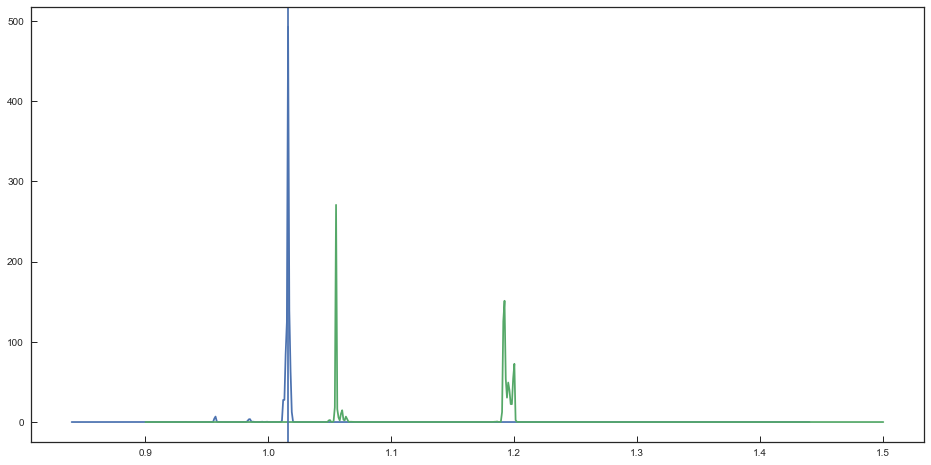

In [53]:
plt.figure(figsize=[16,8])
plt.plot(z,pz)
plt.plot(z2,pz2)
plt.axvline(1.016)

In [52]:
Median_w_Error_cont(pz,z)

(1.016753507014028071, 0.0024048096192384790099, 0.0012024048096192396133)

In [62]:
spec.Median_spec(0.019,4.5,tau)

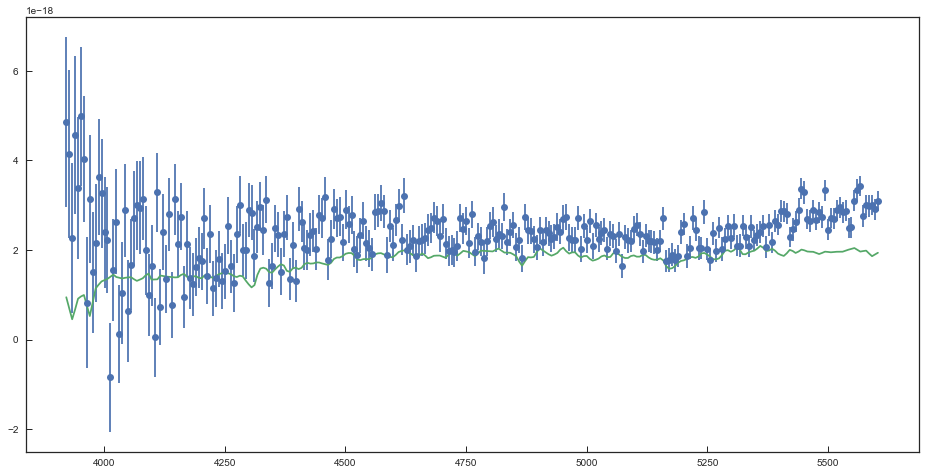

In [63]:
plt.figure(figsize=[16,8])
plt.errorbar(wv1[IDX2]/2.016,stack[IDX2]*1E-17,err[IDX2]*1E-17,fmt='o')
plt.plot(spec.gal_wv_rf,spec.fl)